In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from multiprocessing import Pool
import warnings
#warnings.filterwarnings('ignore')

In [3]:
drugs = ["DAU", "IDA", "Mito", "VP16", "6TG", "2CdA", "FLD", "AraC", "AZC", "DAC", "6MP", "MTX", "AG221", "ABT199","ATRA"]
drugs.sort()
PROJECT_PATH = Path("/home/wak/toprak-lab/aml_drug_synergy")

data_path = PROJECT_PATH / "data/raw_curated_single_file/ETECS02-ETECS03-combined-normalized.tsv"
raw = pd.read_csv(data_path, sep='\t', dtype={'Conc. A [uM]':float, 'Conc. B [uM]':float, 'Masked':object})
raw

,Index,Plate,Plate ID,Row,Column,Compound A,Conc. A [uM],Compound B,Conc. B [uM],Well Type,Masked,Well Tags,Timestamp,Raw,Normalized,Normalized2,Plate Mask,Cell Line,Cell Line+Well Type
0,1,1,ETECS02 FKH1_1,A,1,ATRA,50.000,ATRA,50.0,Compound,NaN,NaN,13.03.2020 01:48:00,963720.0,-25.443290,0.739827,NaN,FKH1,FKH1 Compound
1,2,1,ETECS02 FKH1_1,A,2,ATRA,5.000,ATRA,50.0,Compound,NaN,NaN,13.03.2020 01:48:00,1300880.0,0.640569,1.006550,NaN,FKH1,FKH1 Compound
2,3,1,ETECS02 FKH1_1,A,3,ATRA,0.500,ATRA,50.0,Compound,NaN,NaN,13.03.2020 01:48:00,1262280.0,-2.345660,0.976014,NaN,FKH1,FKH1 Compound
3,4,1,ETECS02 FKH1_1,A,4,ATRA,0.050,ATRA,50.0,Compound,NaN,NaN,13.03.2020 01:48:00,1277200.0,-1.191397,0.987817,NaN,FKH1,FKH1 Compound
4,5,1,ETECS02 FKH1_1,A,5,ATRA,0.005,ATRA,50.0,Compound,NaN,NaN,13.03.2020 01:48:00,1295760.0,0.244469,1.002500,NaN,FKH1,FKH1 Compound
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123573,9212,24,ETECS03 Kasumi1_24,P,20,NaN,NaN,NaN,NaN,Compound,NaN,NaN,26.04.2021 11:32:29,2774720.0,47.481660,1.483074,NaN,Kasumi1,Kasumi1 Compound
123574,9213,24,ETECS03 Kasumi1_24,P,21,NaN,NaN,NaN,NaN,Compound,NaN,NaN,26.04.2021 11:32:29,2819560.0,49.864990,1.507322,NaN,Kasumi1,Kasumi1 Compound
123575,9214,24,ETECS03 Kasumi1_24,P,22,NaN,NaN,NaN,NaN,Compound,NaN,NaN,26.04.2021 11:32:29,2641640.0,40.408210,1.411109,NaN,Kasumi1,Kasumi1 Compound
123576,9215,24,ETECS03 Kasumi1_24,P,23,NaN,NaN,NaN,NaN,Compound,NaN,NaN,26.04.2021 11:32:29,3013280.0,60.161580,1.612078,NaN,Kasumi1,Kasumi1 Compound


In [4]:
with open(PROJECT_PATH / 'data/raw_effect_matrices/raw_effect_matrices_8x8.pkl', 'rb') as f:
    raw_effect_8 = pickle.load(f)

with open(PROJECT_PATH / 'data/raw_effect_matrices/raw_effect_matrices_11x11.pkl', 'rb') as f:
    raw_effect_11 = pickle.load(f)
# with open(PROJECT_PATH / 'dump/models/11x11_synergy_models_and_raw_effect.pkl', 'rb') as f:
#     synergy_models_11, raw_effect_11 = pickle.load(f)

In [5]:
total_exp = 0
print('8x8 screen')
for cell_line in raw_effect_8.keys():
    print(cell_line, len(raw_effect_8[cell_line]))
    total_exp += 8 * 8 * len(raw_effect_8[cell_line])
print('11x11 screen')
for cell_line in raw_effect_11.keys():
    print(cell_line, len(raw_effect_11[cell_line]))
    total_exp += 11 * 11 * len(raw_effect_8[cell_line])
print(total_exp)

8x8 screen
FKH1 120
HL60 120
K562 120
TF1 120
IDH2 105
Kasumi1 120
11x11 screen
FKH1 21
HL60 26
K562 43
TF1 0
IDH2 36
Kasumi1 24
130425


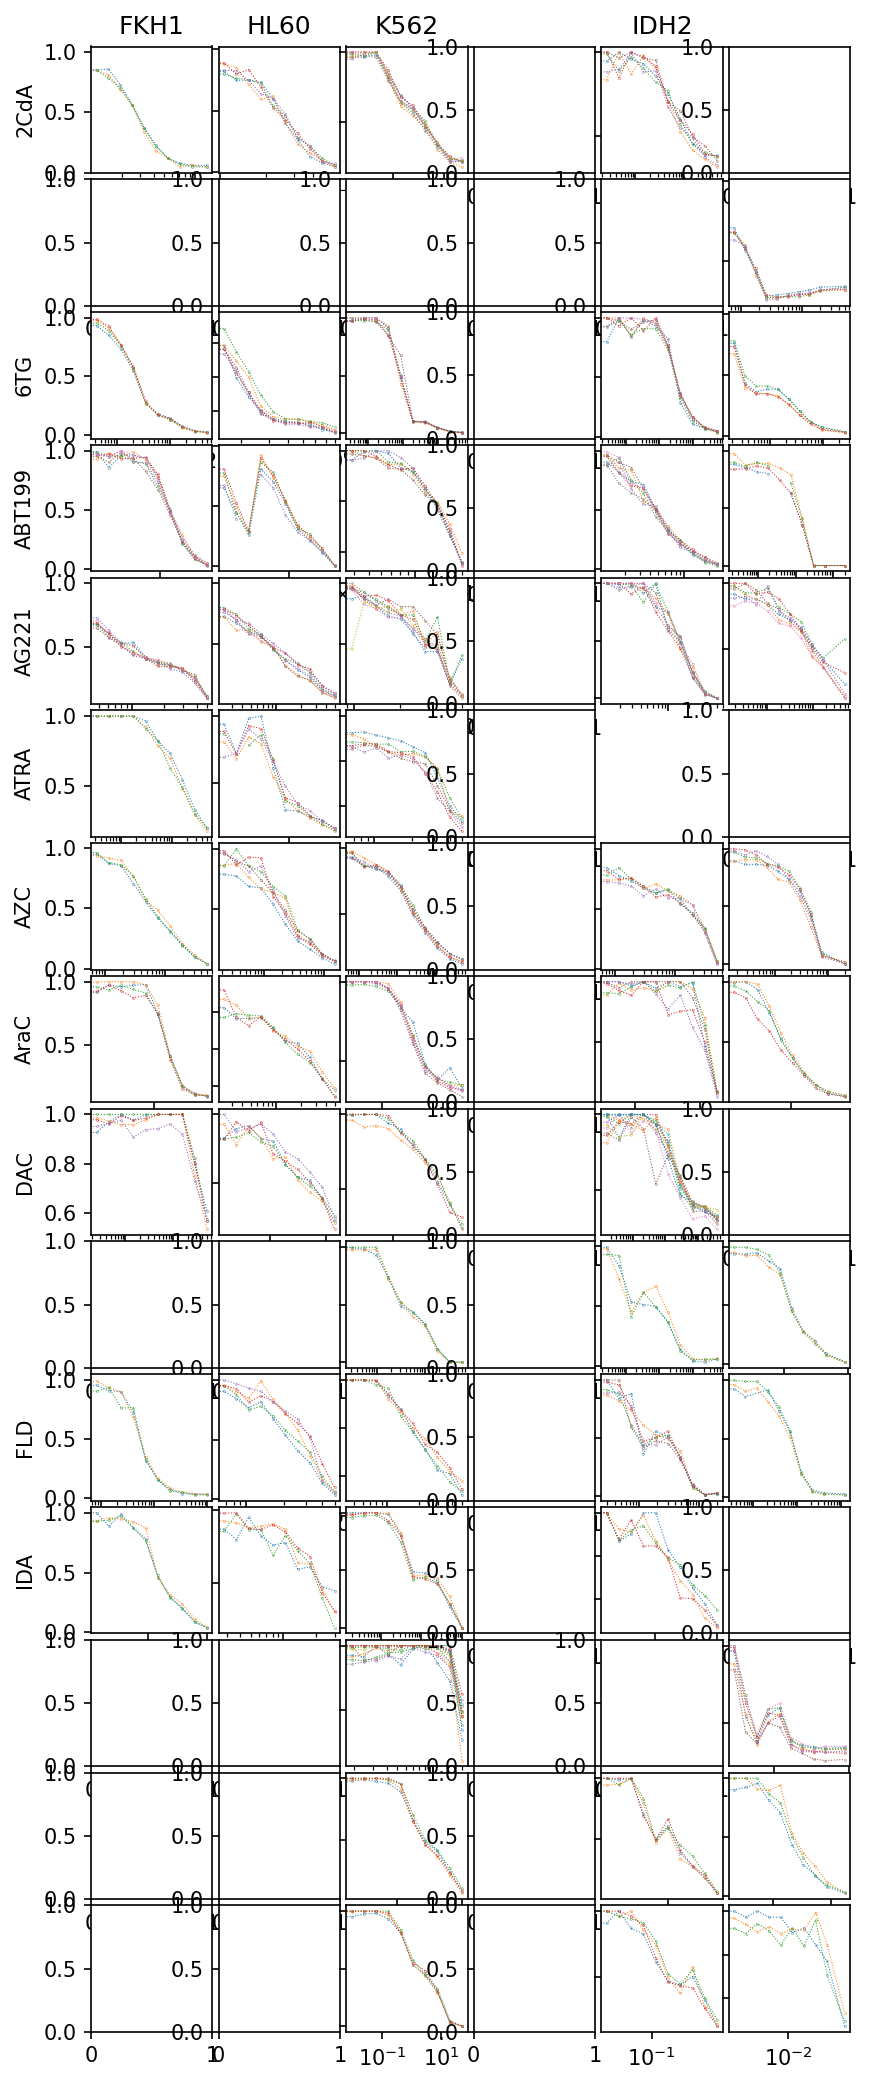

In [6]:
pal = sns.color_palette('tab10')
fig, axes = plt.subplots(15,6, figsize=(6,14), dpi=150)
plt.style.use('default')
plt.rc('axes',labelsize=7)
for axi, cell_line in enumerate(raw_effect_8.keys()):
    for drug_pair in raw_effect_11[cell_line]:
        druga_effect = raw_effect_11[cell_line][drug_pair].iloc[:,0]
        druga_conc = np.array(list(raw_effect_11[cell_line][drug_pair].index))
        drugb_effect = raw_effect_11[cell_line][drug_pair].iloc[0,:]
        drugb_conc = np.array(list(raw_effect_11[cell_line][drug_pair].columns))
        for effect, conc, drugi in [(druga_effect, druga_conc, np.searchsorted(drugs,drug_pair[0])),
                                    (drugb_effect, drugb_conc, np.searchsorted(drugs,drug_pair[1]))]:
            ax = axes[drugi, axi]
            with pal:
                ax.plot(conc, effect, alpha=1, linestyle=':', marker='o', linewidth=0.5, markersize=0.2)
            ax.set_xscale('log')
            if axi!=0:
                ax.set_yticklabels([])
            if drugi!=len(drugs)-1:
                ax.set_xticklabels([])
            if axi==0:
                ax.set_ylabel(drugs[drugi])
            if drugi==0:
                ax.set_title(cell_line)
axes[5,4].set_axis_off()
plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.05)

In [7]:
from scipy.optimize import curve_fit

def sigmoid(x, bpos, bshape):#, b):
    y = 1 / (1 + np.exp(-bshape*(x-bpos)))# + b
    return (y)

def sig_eval(x, bpos, bshape, x_log_base=2):
    """This func evalutes a sigmoid fit done in log in x-axis
    also adjusts first data point from 0 to x[1]/x_log_base.
    """
    xa = np.array(list(x)).copy()
    if xa[0]<1e-7:
        xa[0] = xa[1]/x_log_base
    xa = np.emath.logn(x_log_base, xa)
    return sigmoid(xa, bpos, bshape), xa

def sig_fit(effect, drug_conc, x_log_base=2):
    """This functions assumes drug concentration starts from zero 
    and monotonically increasing."""
    xdata = np.array(list(drug_conc)).copy()
    xdata[0] = xdata[1]/x_log_base
    #horizon0 = [xdata[0]/(x_log_base**i) for i in [2,1]]
    #xdata = np.concatenate((horizon0, xdata))
    xdata[xdata<1e-6] = xdata[0]
    xdata = np.emath.logn(x_log_base, xdata)
    ydata = effect.copy()
    # fit according to relative viability
    ydata = ydata / ydata[0]
    ydata[ydata>1] = 1
    #ydata = np.concatenate(([ydata[0]]*2, ydata))
    # eliminate nans
    nans = (np.isnan(xdata) | np.isnan(ydata))
    xdata = xdata[~nans]
    ydata = ydata[~nans]
    if len(xdata)<len(effect)-2:
        #print('Fit input has too many NaN values.')
        return None, None, None
    # initial parameter estimates
    p0 = [np.median(xdata), -.5]#, min(ydata)]
    try:
        p, pcov = curve_fit(sigmoid, xdata, ydata, p0, bounds=([-np.inf,-np.inf],[np.inf,np.inf]), method='lm', maxfev=10000)
    except BaseException:
        #print('Sigmoid fit did not converge.')
        return None, None, None
    #print(p)
    return p, xdata, ydata

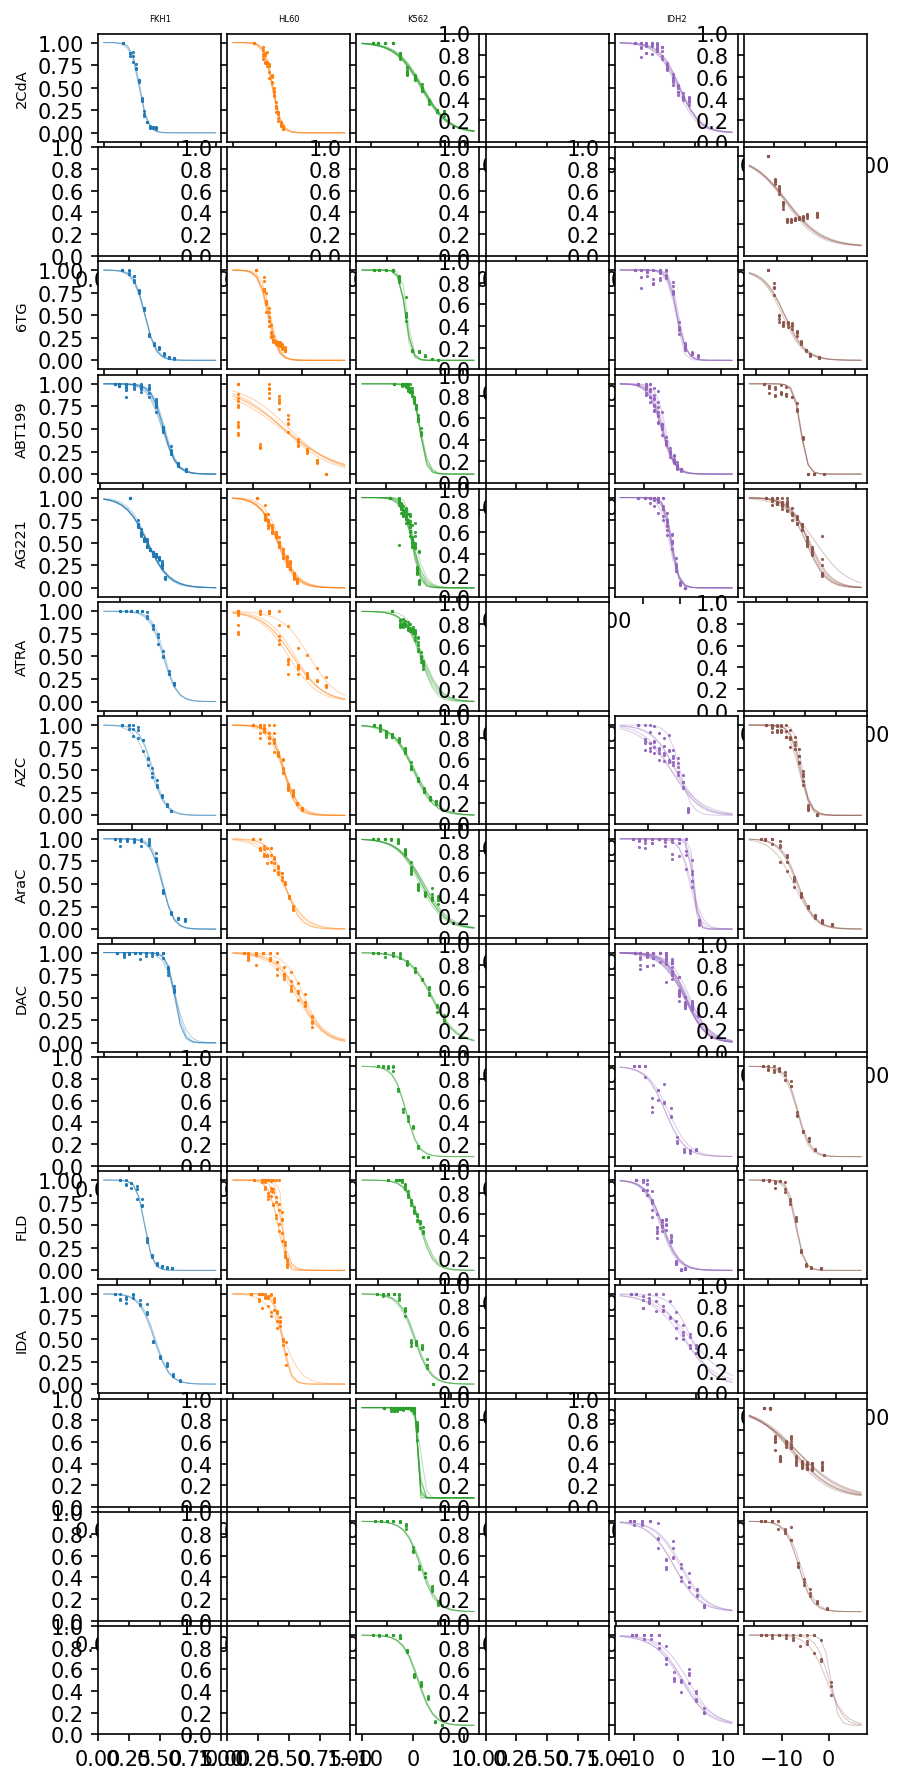

In [8]:
pal = sns.color_palette('tab10')
fig, axes = plt.subplots(15,6, figsize=(6,12), dpi=150)
plt.style.use('default')
plt.rc('axes', labelsize=4, titlesize=4)
plt.rc('xtick', labelsize=4)
plt.rc('ytick', labelsize=4)

single_drc_models = {}
sig_effect_11 = {}

for axi, cell_line in enumerate(raw_effect_8.keys()):
    # create bliss estimated effect matrices
    sig_effect_11[cell_line] = {}
    for drug_pair in raw_effect_11[cell_line]:
        # start from the raw effect matrix
        sig_effect_11[cell_line][drug_pair] = []
        # collect single drug response at each drug pair
        druga_effect = raw_effect_11[cell_line][drug_pair].iloc[:,0]
        druga_conc = np.array(list(raw_effect_11[cell_line][drug_pair].index))
        drugb_effect = raw_effect_11[cell_line][drug_pair].iloc[0,:]
        drugb_conc = np.array(list(raw_effect_11[cell_line][drug_pair].columns))
        # single drc sigmoid estimations
        for effect, conc, drugi in [(druga_effect, druga_conc, np.searchsorted(drugs,drug_pair[0])),
                                    (drugb_effect, drugb_conc, np.searchsorted(drugs,drug_pair[1]))]:
            ax = axes[drugi, axi]
            p, x, y = sig_fit(effect, conc)
            # record sigmoid fit params here
            sig_effect_11[cell_line][drug_pair].append(p)
            # if fit successful plot results
            if p is not None:
                x_fit = np.logspace(int(x[0])-3, int(x[-1])+7, 20, base=2)
                y_fit, x_fit = sig_eval(x_fit, *p)
                ax.plot(x, y,'o', color=pal[axi], markersize=0.5)
                ax.plot(x_fit, y_fit, color=pal[axi], linewidth=0.5, alpha=0.33)
                ax.set_ylim([-0.1,1.1])
                # with pal:
                #     ax.plot(conc, effect, alpha=1, linestyle=':', marker='o', linewidth=0.5, markersize=0.2)
            if axi!=0:
                ax.set_yticklabels([])
            if drugi!=14:
                ax.set_xticklabels([])
            if drugi==0:
                ax.set_title(cell_line)
            if axi==0:
                ax.set_ylabel(drugs[drugi])
axes[5,4].set_axis_off()
plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.05)

Compare observed drug effects vs. Bliss estimations

In [9]:
raw_effect_11.keys()

dict_keys(['FKH1', 'HL60', 'K562', 'TF1', 'IDH2', 'Kasumi1'])

In [10]:
pal = sns.color_palette('tab10')
pal2 = sns.color_palette('tab20')
plt.rc('axes', titlesize=4)
plt.rc('xtick', labelsize=4)
plt.rc('ytick', labelsize=4)

export_path = PROJECT_PATH / "dump/sigmoid_synergy_estimations/bliss_v_observed_11"
export_path.mkdir(parents=True,exist_ok=True)

ax_count = 0
bliss_effect_11 = {}
bliss_sig_effect_11 = {}
raw_sig_effect_11 = {}
dic50_11 = []
for axi, cell_line in enumerate(raw_effect_11.keys()):
    bliss_effect_11[cell_line] = {}
    bliss_sig_effect_11[cell_line] = {}
    raw_sig_effect_11[cell_line] = {}
    
    drug_pair_count = len(raw_effect_11[cell_line])
    if drug_pair_count < 1:
        continue
    fig, axes = plt.subplots(drug_pair_count, 11, figsize=(11, drug_pair_count), dpi=300)
    for drug_count, drug_pair  in enumerate(raw_effect_11[cell_line]):
        bliss_effect_11[cell_line][drug_pair] = raw_effect_11[cell_line][drug_pair].copy()
        bliss_sig_effect_11[cell_line][drug_pair] = []
        raw_sig_effect_11[cell_line][drug_pair] = []

        druga_effect = raw_effect_11[cell_line][drug_pair].iloc[:,0]
        druga_conc = np.array(list(raw_effect_11[cell_line][drug_pair].index))
        sig_params_druga = sig_effect_11[cell_line][drug_pair][0]

        drugb_effect = raw_effect_11[cell_line][drug_pair].iloc[0,:]
        drugb_conc = np.array(list(raw_effect_11[cell_line][drug_pair].columns))
        sig_params_drugb = sig_effect_11[cell_line][drug_pair][1]

        if sig_params_druga is not None and sig_params_drugb is not None:
            druga_sig_effect, xa = sig_eval(druga_conc, *sig_params_druga)
            drugb_sig_effect, xa = sig_eval(drugb_conc, *sig_params_drugb)
            
            bliss_effect_11[cell_line][drug_pair].iloc[:,:] = druga_sig_effect[np.newaxis].T * drugb_sig_effect

            for drugb_knob in range(11):
                raw_effect = raw_effect_11[cell_line][drug_pair].iloc[:,drugb_knob]
                bliss_effect = bliss_effect_11[cell_line][drug_pair].iloc[:,drugb_knob]
                conc = druga_conc
                bp, bx, by = sig_fit(bliss_effect, conc)
                rp, rx, ry = sig_fit(raw_effect, conc)
                # record sigmoid fit params here
                bliss_sig_effect_11[cell_line][drug_pair].append(bp)
                raw_sig_effect_11[cell_line][drug_pair].append(rp)
                # pick axes
                ax = axes[drug_count, drugb_knob]
                # if fit successful plot results
                if bp is not None and rp is not None:
                    x_fit = np.logspace(int(bx[0])-3, int(bx[-1])+7, 20, base=2)
                    by_fit, bx_fit = sig_eval(x_fit, *bp)
                    ry_fit, rx_fit = sig_eval(x_fit, *rp)
                    ax.plot(bx, by,'o', color=pal[0], markersize=0.5, alpha=0.8)
                    ax.plot(bx_fit, by_fit, color=pal[0], linewidth=0.5, alpha=0.8)
                    ax.plot(rx, ry,'^', color=pal[1], markersize=0.5, alpha=0.8)
                    ax.plot(rx_fit, ry_fit, color=pal[1], linewidth=0.5, alpha=0.8)
                    
                    # if sufficient killing was achieved
                    if by_fit[-1]>0.05:
                        ax.text(0.12, 1.015, f"INVALID:INSUFFICIENT ANCHOR", color='red', fontsize=3, weight='bold', transform=ax.transAxes)
                        dic50_11.append({'cell_line':cell_line, 'drugA': drug_pair[0], 'drugB': drug_pair[1],
                                    'drugB_conc':raw_effect_11[cell_line][drug_pair].columns[drugb_knob],
                                    'dIC50': np.nan, 'valid': 'INVALID:INSUFFICIENT ANCHOR KILLING'})
                    elif ry_fit[-1]>0.05:# and bliss_effect.values[-1]<=0.66:
                        ax.text(0.12, 1.015, f"INVALID:INSUFFICIENT LIBRARY", color='red', fontsize=3, weight='bold', transform=ax.transAxes)
                        dic50_11.append({'cell_line':cell_line, 'drugA': drug_pair[0], 'drugB': drug_pair[1],
                                    'drugB_conc':raw_effect_11[cell_line][drug_pair].columns[drugb_knob],
                                    'dIC50': np.nan, 'valid': 'INVALID:INSUFFICIENT LIBRARY KILLING'})
                    else:
                    # ax.text(0.1, 0.1, f"bshape={bp[1]:.1f}", color=pal[0], fontsize=4, weight='bold', transform=ax.transAxes)
                    # ax.text(0.1, 0.01, f"bshape={rp[1]:.1f}", color=pal[1], fontsize=4, weight='bold', transform=ax.transAxes)
                        dIC50 = rp[0]-bp[0]
                        dic50_11.append({'cell_line':cell_line, 'drugA': drug_pair[0], 'drugB': drug_pair[1],
                                    'drugB_conc':raw_effect_11[cell_line][drug_pair].columns[drugb_knob],
                                    'dIC50': dIC50, 'valid': 'VALID'})
                        ax.text(0.01, 1.015, f"IC50={bp[0]:.1f}", color=pal[0], fontsize=4, weight='bold', transform=ax.transAxes)
                        ax.text(0.63, 1.015, f"IC50={rp[0]:.1f}", color=pal[1], fontsize=4, weight='bold', transform=ax.transAxes)
                        ax.text(0.37, 1.015, f"{dIC50:+.1f}", color=['red','green'][int(rp[0]<(bp[0]-1))], fontsize=4, weight='bold', transform=ax.transAxes)

                # if fit not successful
                else:
                    ax.plot(conc, bliss_effect, 'o', color=pal[0], markersize=0.5, alpha=0.8)
                    ax.plot(conc, raw_effect, '^', color=pal[1], markersize=0.5, alpha=0.8)
                    ax.text(0.01, 1.015, f"INVALID:BLISS FIT FAILED", color='red', fontsize=4, weight='bold', transform=ax.transAxes)
                    dic50_11.append({'cell_line':cell_line, 'drugA': drug_pair[0], 'drugB': drug_pair[1],
                                    'drugB_conc':raw_effect_11[cell_line][drug_pair].columns[drugb_knob],
                                    'dIC50': np.nan, 'valid': 'INVALID:BLISS FIT FAILED'})
                # plot yticks only at first column
                if drugb_knob!=0:
                    ax.set_yticks([])
                ax.set_title(f"{drug_pair[0]}@{drug_pair[1]}={raw_effect_11[cell_line][drug_pair].columns[drugb_knob]:.4f}ug/ml", fontsize=4, weight='bold')
                ax.set_ylim([-0.1,1.1])
        # if single drc fit not successful
        else:
            ax = axes[drug_count, 0]
            ax.plot(conc, druga_effect, 'o', color=pal[0], markersize=1, alpha=0.5)
            ax.plot(conc, drugb_effect, '^', color=pal[1], markersize=1, alpha=0.5)
            ax.text(0.01, 1.015, f"INVALID:SINGLE DRUG FIT FAILED", color='red', fontsize=4, weight='bold', transform=ax.transAxes)
            for drugb_knob in range(11):
                dic50_11.append({'cell_line':cell_line, 'drugA': drug_pair[0], 'drugB': drug_pair[1],
                                'drugB_conc':raw_effect_11[cell_line][drug_pair].columns[drugb_knob],
                                'dIC50': np.nan, 'valid': 'INVALID:SINGLE DRUG FIT FAILED'})
            ax.set_title(f"{drug_pair[0]}@{drug_pair[1]}", fontsize=4, weight='bold')
            ax.set_ylim([-0.1,1.1])
            for axc in range(1,11):
                axes[drug_count, axc].set_axis_off()
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.05, hspace=0.5)
    fig.savefig(export_path / f"{cell_line}.png", dpi=300)
    plt.close(fig)
    print(f"{cell_line} complete.")
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.8)

/home/wak/micromamba/envs/data311/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


FKH1 complete.
HL60 complete.


/tmp/ipykernel_24497/2917337537.py:4: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-bshape*(x-bpos)))# + b


K562 complete.
IDH2 complete.
Kasumi1 complete.


<Figure size 640x480 with 0 Axes>

In [11]:
dic50_df = pd.DataFrame(dic50_11)
dic50_df.to_csv(PROJECT_PATH / 'dump/sigmoid_synergy_estimations/bliss_v_observed_11_delta_ic50.csv', index=False)
dic50_df

,cell_line,drugA,drugB,drugB_conc,dIC50,valid
0,FKH1,2CdA,2CdA,0.000000,-0.014749,VALID
1,FKH1,2CdA,2CdA,0.011383,-0.329797,VALID
2,FKH1,2CdA,2CdA,0.014798,-0.573117,VALID
3,FKH1,2CdA,2CdA,0.019238,-0.661100,VALID
4,FKH1,2CdA,2CdA,0.025009,-0.650452,VALID
...,...,...,...,...,...,...
1645,Kasumi1,VP16,VP16,0.014600,-0.085902,VALID
1646,Kasumi1,VP16,VP16,0.041000,0.234032,VALID
1647,Kasumi1,VP16,VP16,0.115000,-0.428415,VALID
1648,Kasumi1,VP16,VP16,0.321000,NaN,INVALID:INSUFFICIENT LIBRARY KILLING


In [12]:
def classify_max(x):
    if np.median(x[1:])>0:
        return np.max(x)
    elif np.median(x[1:])<0:
        return np.min(x)
    else:
        return np.nanmedian(x[1:])
    
df_max = dic50_df.groupby(['cell_line', 'drugA', 'drugB'])['dIC50'].agg(classify_max).to_frame().reset_index()
df_max = df_max[ ~(df_max['drugA']==df_max['drugB']) ]

for cell_line in raw_effect_11.keys():
    df = df_max[df_max['cell_line']==cell_line]
    dfp = df.pivot(index=['drugA'], columns=['drugB'], values=['dIC50']).droplevel(level=0,axis=1)
    sns.set_theme(style="white")
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(-dfp, cmap=cmap, vmax=5, center=0, vmin=-5,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},
                xticklabels=dfp.columns, yticklabels=dfp.index)
    ax.tick_params(axis='x',labelsize=10)
    ax.set_title(cell_line)
    f.savefig(PROJECT_PATH / f'dump/sigmoid_synergy_estimations/bliss_v_observed_11_delta_ic50_heatmaps/{cell_line}_dic50_heatmap.png', dpi=300)
    plt.close(f)

/tmp/ipykernel_24497/85000227.py:7: RuntimeWarning: All-NaN slice encountered
  return np.nanmedian(x[1:])
/home/wak/micromamba/envs/data311/lib/python3.11/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/home/wak/micromamba/envs/data311/lib/python3.11/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


/tmp/ipykernel_24497/85000227.py:7: RuntimeWarning: All-NaN slice encountered
  return np.nanmedian(x[1:])
/home/wak/micromamba/envs/data311/lib/python3.11/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/home/wak/micromamba/envs/data311/lib/python3.11/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/tmp/ipykernel_24497/383715174.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


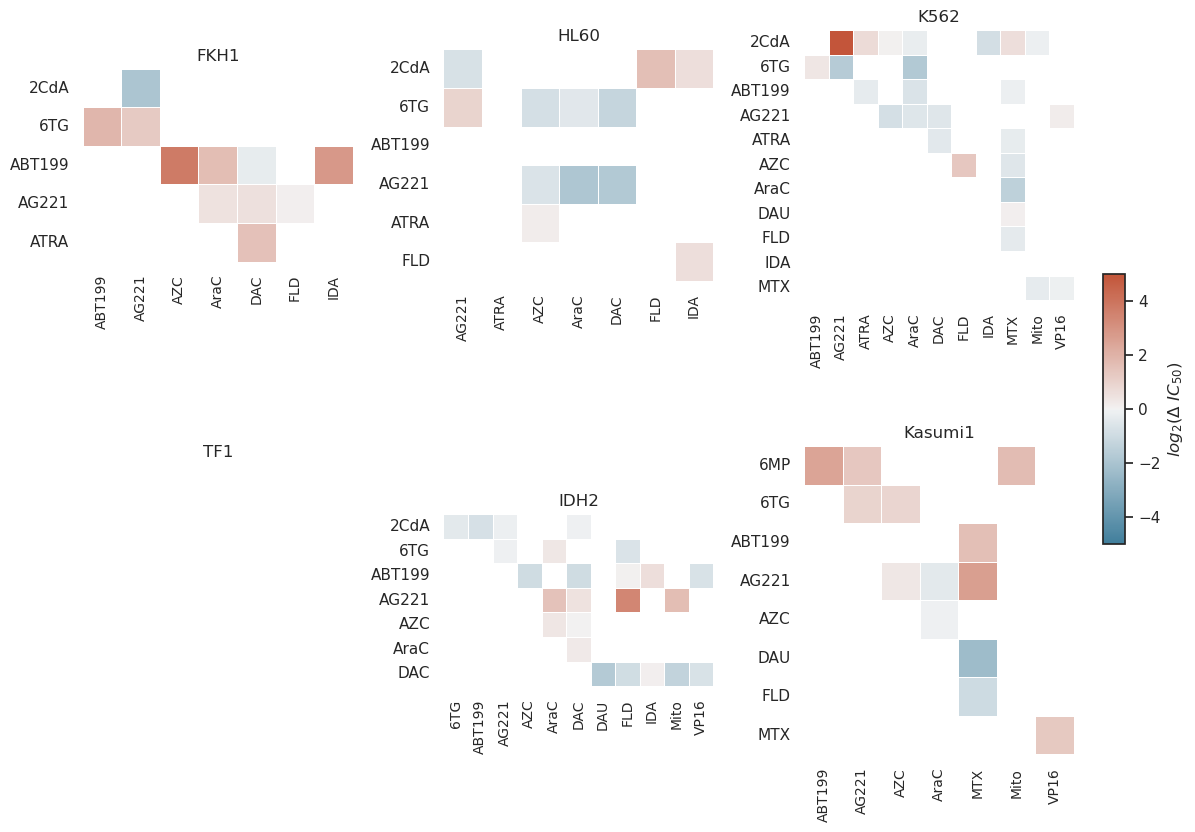

In [13]:
# get max
#df_max = dic50_df.groupby(['cell_line', 'drugA', 'drugB'])['dIC50'].agg(min).to_frame().reset_index()
# get mean of max 2
#df_max = dic50_df.groupby(['cell_line', 'drugA', 'drugB'])['dIC50'].agg(lambda x: np.mean(np.sort(np.array(x)[0:2]))).to_frame().reset_index()
# first classify as synergistic, antagonistic, independence, than select max
df_max = dic50_df.groupby(['cell_line', 'drugA', 'drugB'])['dIC50'].agg(classify_max).to_frame().reset_index()
df_max = df_max[ ~(df_max['drugA']==df_max['drugB']) ]

sns.set_theme(style="white")
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Set up the matplotlib figure
f, axes = plt.subplots(2,3,figsize=(11, 9))

for ploti, cell_line in enumerate(raw_effect_8.keys()):
    ax = axes.flat[ploti]
    df = df_max[df_max['cell_line']==cell_line]
    dfp = df.pivot(index=['drugA'], columns=['drugB'], values=['dIC50']).droplevel(level=0,axis=1)
    # Draw the heatmap with the mask and correct aspect ratio
    hax = sns.heatmap(-dfp, ax=ax, cmap=cmap, vmax=5, center=0, vmin=-5,
                square=True, linewidths=.5, 
                xticklabels=dfp.columns, yticklabels=dfp.index,
                cbar=False, cbar_kws={"shrink": .5, "location":"right"})
    #ax.set_xticklabels(dfp.columns)
    ax.tick_params(axis='x',labelsize=10)
    ax.set_title(cell_line)
    ax.set_xlabel('')
    ax.set_ylabel('')
    # if not(ploti in [0,3]):
    #     ax.set_yticklabels([])
    # if ploti in [0,1,2]:
    #     ax.set_xticklabels([])
cbar_ax = f.add_axes([1.01, 0.35, 0.02, 0.3])
f.colorbar(hax.get_children()[0], cax=cbar_ax, label='$log_{2}(\Delta~IC_{50}$)')
f.tight_layout()
#f.subplots_adjust(hspace=-0.05)
f.savefig(PROJECT_PATH / f'dump/sigmoid_synergy_estimations/bliss_v_observed_11_delta_ic50_heatmaps/dic50_heatmap_by_drug_pair_11x11.png', dpi=600)

In [19]:
dfp = df_max.pivot(index=['drugA','drugB'],columns=['cell_line'])
# filter out drug pairs with less than two cell lines
dfp_filt = dfp[dfp.apply(lambda x: sum(~pd.isna(x))>0,axis=1)]
# filter out cell lines that does not have greater than 2 fold change in at least one cell line
dfp_filt = dfp_filt[dfp_filt.apply(lambda x: ((x>1).any() or (x<-1).any()),axis=1)]

for i, r in dfp_filt.iterrows():
    dfp_filt.loc[(i[1],i[0]),:] = dfp_filt.loc[i,:]
dfp_filt.sort_index(inplace=True)
print(dfp_filt.shape)

(50, 5)


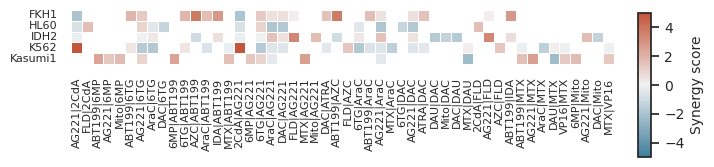

In [21]:
fig, axes = plt.subplots(1,1)
for axi, r in enumerate([range(0,dfp_filt.shape[0])]):
    ax = axes
    hax = sns.heatmap(-dfp_filt.T.iloc[:,r], ax=ax, cmap=cmap, vmax=5, center=0, vmin=-5,
                    square=True, linewidths=.5, 
                    xticklabels=[f'{l[1]}|{l[0]}' for l in dfp_filt.index[r]],
                    yticklabels=dfp.columns.get_level_values(1),
                    cbar=False, cbar_kws={"shrink": .5, "location":"right"})
    ax.tick_params(labelsize=8)
    ax.set_ylabel('')
    ax.set_xlabel('')
fig.tight_layout()
cbar_ax = fig.add_axes([1.01, 0.25, 0.02, 0.3])
cbar = fig.colorbar(hax.get_children()[0], cax=cbar_ax)
cbar.set_label(label='Synergy score', size=10)
cbar.ax.tick_params(labelsize=10)
fig.subplots_adjust(hspace=0.0)
fig.savefig(PROJECT_PATH / f'dump/sigmoid_synergy_estimations/bliss_v_observed_11_delta_ic50_heatmaps/dic50_heatmap_by_cell_line_11x11.png',
            dpi=600, bbox_inches='tight')

In [17]:
significant_pairs = df_max[df_max['dIC50']<-1].sort_values(by='dIC50',ascending=True)
all_pairs = df_max.sort_values(by='dIC50',ascending=True)

# all_pairs.to_csv(PROJECT_PATH / 'dump/sigmoid_synergy_estimations/All synergistic pairs 11x11.csv',index=False)
# significant_pairs.to_csv(PROJECT_PATH / 'dump/sigmoid_synergy_estimations/Significant synergistic pairs 11x11.csv',index=False)

all_pairs.to_csv(PROJECT_PATH / 'figures/Supplementary Table 3. All synergy scores from 11-by-11.csv',index=False)
significant_pairs.to_csv(PROJECT_PATH / 'figures/Supplementary Table 3. Significant synergy scores from 11-by-11.csv',index=False)

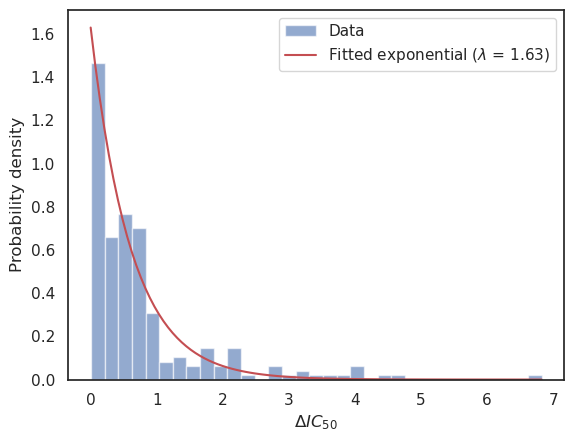

In [229]:
from scipy.optimize import curve_fit
data = -df_max.loc[df_max['dIC50']<0, 'dIC50']  # scale = 1/lambda
# Estimate the rate parameter (lambda) of the exponential distribution
lambda_estimated = 1 / np.mean(data)
# Defining exponential function to fit
def exp_func(x, lamb):
    return lamb * np.exp(-lamb * x)
# Histogram of the data
n, bins, patches = plt.hist(data, bins=33, density=True, alpha=0.6, label='Data')
# Fitting the exponential function
x = np.linspace(0, np.max(data), 100)
bin_centers = (bins[:-1] + bins[1:]) / 2
params, covariance = curve_fit(exp_func, bin_centers, n)
# Plotting the fitted distribution
y = exp_func(x, *params)
plt.plot(x, y, 'r-', label=f'Fitted exponential ($\lambda$ = {params[0]:.2f})')
# Add labels and legend
plt.xlabel('$\Delta IC_{50}$')
plt.ylabel('Probability density')
plt.legend()
# Show plot
plt.show()

1.253117849693888

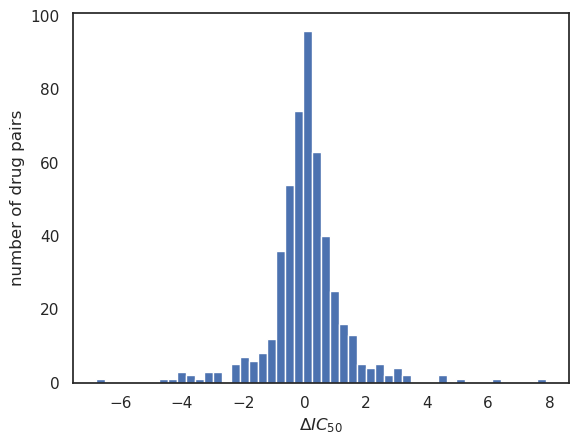

In [204]:
plt.hist(df_max['dIC50'],50);
plt.ylabel('number of drug pairs')
plt.xlabel('$\Delta IC_{50}$')
np.std(df_max['dIC50'])

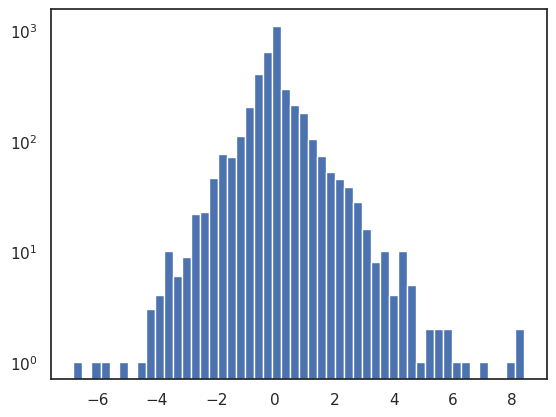

In [194]:
plt.hist(dic50_df['dIC50'],50);
plt.yscale('log')

In [78]:
dic50_valid = dic50_df[dic50_df['valid']=='VALID']
df = dic50_valid.groupby(['cell_line','drugA','drugB','drugB_conc'])['dIC50'].agg(lambda x: x)
df

cell_line  drugA  drugB  drugB_conc
FKH1       2CdA   2CdA   0.000000     -0.090403
                         0.026337      4.216407
                  6TG    0.000000     -0.091365
                         2.980232     -0.096201
                         4.768372     -0.100396
                                         ...   
TF1        VP16   VP16   0.874257      0.532602
                         2.404207      0.887660
                         6.611570      1.188844
                         18.181820     2.040897
                         50.000000     2.708196
Name: dIC50, Length: 3825, dtype: float64

In [109]:
# merge two cell lines on the common IC50 shift estimations
dic_comp = pd.merge(left=df.loc['K562'], right=df.loc['Kasumi1'], on=['drugA', 'drugB', 'drugB_conc']).reset_index()
# remove same drug combinations
dic_comp = dic_comp[dic_comp['drugA']!=dic_comp['drugB']]
# index by pair name
dic_comp.insert(0, 'drug_pair', dic_comp['drugA'] + '_' + dic_comp['drugB'])
dic_comp.drop(['drugA', 'drugB'], axis=1, inplace=True)
dic_comp

,drug_pair,drugB_conc,dIC50_x,dIC50_y
0,2CdA_6MP,0.0,-0.435920,-5.107026e-14
1,2CdA_6TG,0.0,-0.205067,-3.996803e-14
2,2CdA_AZC,0.0,-0.544773,8.973773e-08
3,2CdA_DAC,0.0,-0.419981,8.699272e-04
4,2CdA_DAU,0.0,-0.263434,1.776357e-15
...,...,...,...,...
82,IDA_Mito,0.0,-0.054617,-2.276848e-02
83,IDA_VP16,0.0,-0.045924,-4.972015e-03
85,MTX_Mito,0.0,-0.075606,-2.080439e+00
86,MTX_VP16,0.0,-0.013627,-2.211103e+00


In [112]:
dic_comp_min2 = dic_comp.set_index('drug_pair').loc[ dic_comp.groupby(['drug_pair'])['drugB_conc'].agg(len)>1 ].reset_index()

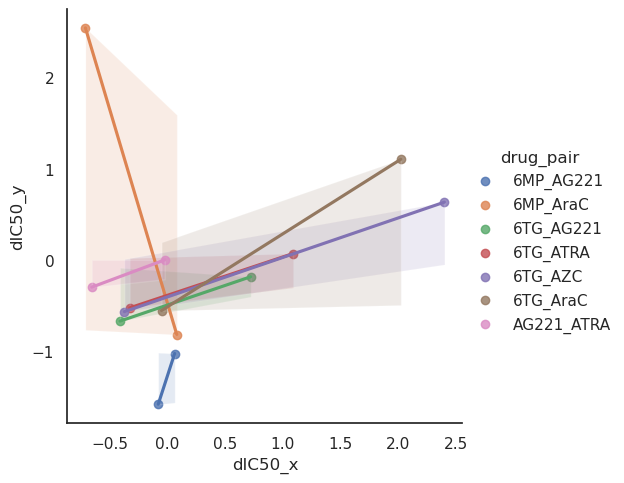

In [113]:
sns.lmplot(
    data=dic_comp_min2,
    x="dIC50_x", y="dIC50_y", hue="drug_pair",
    height=5
)

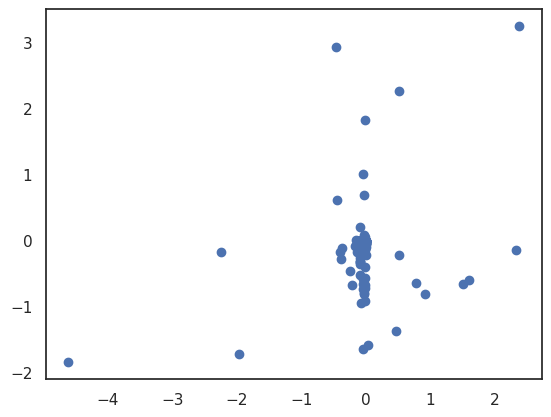

In [86]:
plt.scatter(dic_comp['dIC50_x'], dic_comp['dIC50_y'])

In [177]:
np.array([4,1,9,5]).sort()

In [179]:
df_max = dic50_df.groupby(['cell_line', 'drugA', 'drugB'])['dIC50'].agg(lambda x: np.mean(np.sort(np.array(x)[0:2]))).to_frame().reset_index()
df_max = df_max[ ~(df_max['drugA']==df_max['drugB']) ]
df_max['dIC50'] = -df_max['dIC50']
df_max

,cell_line,drugA,drugB,dIC50
1,FKH1,2CdA,6MP,NaN
2,FKH1,2CdA,6TG,0.093783
3,FKH1,2CdA,ABT199,0.088867
4,FKH1,2CdA,AG221,0.092593
5,FKH1,2CdA,ATRA,0.087292
...,...,...,...,...
697,TF1,IDA,Mito,-0.222915
698,TF1,IDA,VP16,-0.106733
700,TF1,MTX,Mito,NaN
701,TF1,MTX,VP16,0.044945


In [138]:
dic_max_comp = pd.merge(left=df_max[df_max['cell_line']=='FKH1'].drop('cell_line',axis=1), right=df_max[df_max['cell_line']=='HL60'].drop('cell_line',axis=1), on=['drugA', 'drugB'])
dic_max_comp['drug_pair'] = dic_max_comp['drugA'] + "_" + dic_max_comp['drugB']
dic_max_comp.drop(['drugA','drugB'],axis=1,inplace=True)
dic_max_comp = dic_max_comp[(dic_max_comp['dIC50_x']>=1) | (dic_max_comp['dIC50_y']>=1)]
dic_max_comp

,dIC50_x,dIC50_y,drug_pair
2,0.285354,2.137171,2CdA_ABT199
6,0.108527,1.367620,2CdA_AraC
7,0.106294,1.271212,2CdA_DAC
9,0.094653,2.140122,2CdA_FLD
19,NaN,1.149223,6MP_AraC
27,2.124312,0.012031,6TG_ABT199
28,1.762509,1.919549,6TG_AG221
34,0.087983,1.004208,6TG_FLD
39,1.958477,3.947345,ABT199_AG221
40,0.047350,1.643891,ABT199_ATRA


(-0.23118031754430257,
 7.262001415184267,
 -0.3285683531278677,
 7.164613379600701)

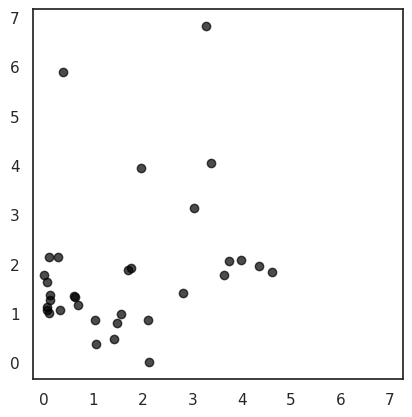

In [139]:
plt.scatter(dic_max_comp['dIC50_x'], dic_max_comp["dIC50_y"], color='black',alpha=0.7)
plt.axis('square')

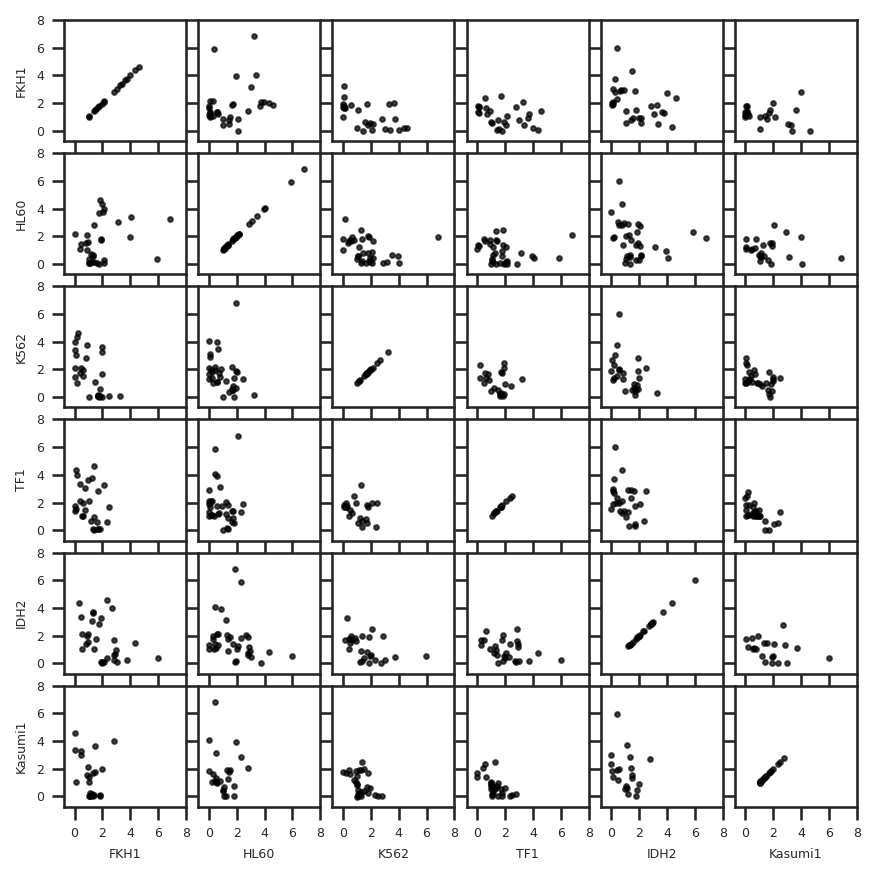

In [170]:
def scatter_pairwise_cell_line(cellA, cellB, ax):
    dic_max_comp = pd.merge(left=df_max[df_max['cell_line']==cellA].drop('cell_line',axis=1), right=df_max[df_max['cell_line']==cellB].drop('cell_line',axis=1), on=['drugA', 'drugB'])
    dic_max_comp['drug_pair'] = dic_max_comp['drugA'] + "_" + dic_max_comp['drugB']
    dic_max_comp.drop(['drugA','drugB'],axis=1,inplace=True)
    # show only drug pairs that have greater than 2 fold dIC50
    dic_max_comp = dic_max_comp[(dic_max_comp['dIC50_x']>=1) | (dic_max_comp['dIC50_y']>=1)]
    ax.scatter(dic_max_comp['dIC50_x'], dic_max_comp["dIC50_y"], s=5, color='black',alpha=0.7)
    ax.set_xlim([-0.75,8])
    ax.set_ylim([-0.75,8])
    ax.set_yticks(list(range(9)))
    ax.set_xticks(list(range(9)))
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
    #ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
    #ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    ax.tick_params(labelsize=6)
    #ax.axis('square')

fig, axes = plt.subplots(6,6, figsize=(6,6), dpi=150)
for ploti, cell_line_i in enumerate(raw_effect_8.keys()):
    for plotj, cell_line_j in enumerate(raw_effect_8.keys()):
        ax = axes[ploti, plotj]
        scatter_pairwise_cell_line(cell_line_i, cell_line_j, ax)
        if plotj!=0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(cell_line_i,fontsize=6)
        if ploti!=5:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel(cell_line_j,fontsize=6)
fig.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.1)